In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from scipy.ndimage import convolve
import requests
from io import BytesIO

## <span style="color:orange;"> 1. Connecting the Camera </span>

This time, we will be recording our own videos using the Arducam HM01B0, which is a small camera that can be hooked up to the Pico. 

### Wiring Instructions

Please make sure your microcontroller is not plugged to the computer while you are wiring things together. Ask the instructor if you are unsure about your wiring. Use your jumper wires to make the following connections.

| HM01B0 | Pico |
|--------|------|
| VCC    | 3V3  |
| SCL    | GP5  |
| SDA    | GP4  |
| VSYNC  | GP16 |
| HREF   | GP15 |
| PCLK   | GP14 |
| DO     | GP6  |
| GND    | GND  |

<!-- ![img](camera.jpg)

*Wiring the Arducam HM01B0 camera* 

![img](camerawiring.jpg)

*Connections to the PICO on breadboard* -->


After ensuring that the wiring is correct, hold down the BOOTSEL button on the Pico and plug it in. Download [arducam.uf2](https://github.com/TheDataScienceLabs/DataLab_Multivariate_Calculus/blob/main/book/labs/2_Video_Labs/arducam.uf2) and copy it onto the Pico's drive, which should have popped up in your folders as an option. The Pico should automatically disconnect once the file has transferred, then its LED will start blinking rapidly. 

Once the Pico has been successfully connected, run the following cell to make sure we have detected the Pico successfully.

In [6]:
import time
import serial
from serial.tools import list_ports

PICO_HWID = "2E8A"


def get_pico_port():
    pico_ports = list(list_ports.grep(PICO_HWID))
    if len(pico_ports) == 0:
        raise Exception(
            "No Raspberry Pi Pico was detected. Check to make sure it is plugged in, and that no other programs are accessing it"
        )
    return pico_ports[0].device


print("Here are all the serial devices detected:")
for port in list_ports.comports():
    print(port.device, port.hwid)

port = get_pico_port()
print(f"\nselected port {port} as most likely to have a raspberry pi pico")

Here are all the serial devices detected:
COM4 BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_VID&0001004C_PID&2012\7&FACD1E3&0&F8665A0717CC_C00000000
COM3 BTHENUM\{00001101-0000-1000-8000-00805F9B34FB}_LOCALMFG&0000\7&FACD1E3&0&000000000000_00000000
COM5 USB VID:PID=2E8A:000A SER=E66118604B5F7321 LOCATION=1-4

selected port COM5 as most likely to have a raspberry pi pico


### <span style="color:red;"> Assignment: Capture a still image </span>

Run the following cell to capture a rectangular piece of paper. The image should contrast with its background. We will be using this image to practice image processing. 

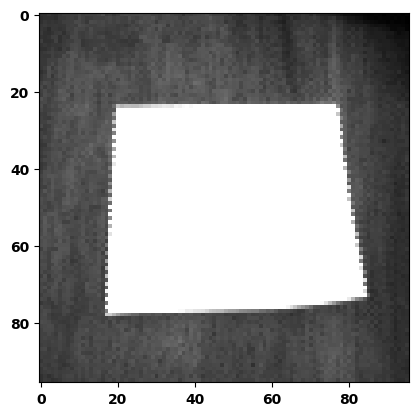

In [15]:
buffer = bytearray(96 * 96)
sticky_note_img = np.zeros(shape=(96, 96), dtype="uint8")

with serial.Serial(port, timeout=1) as s:
    s.read_until(b"\x55\xAA")
    s.readinto(buffer)
    sticky_note_img.flat[::-1] = buffer

plt.imshow(sticky_note_img, cmap="gray")
plt.show()

### Saving an image

In [3]:
def save_array_as_png(array, file_name):
    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(np.uint8(array))

    # Save the image
    image.save(file_name, 'PNG')


save_array_as_png(sticky_note_img, r'figures/sticky_note.png')

NameError: name 'sticky_note_img' is not defined

In [4]:
sticky_note_img = Image.open(r'figures/sticky_note.png').convert('L')

## <span style="color:orange;"> 2. Convolution </span>

### 2.1. Convolution with a Gaussian kernel

The gaussian kernel is a kernel that is used to blur images and remove noise. It is a 2D kernel that is defined as follows:

$$
G(x,y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}
$$

where $\sigma$ is the standard deviation of the gaussian distribution.

In the following cell, we will implement a function that generates a gaussian kernel of size $n\times n$ with standard deviation $\sigma$.

(-0.5, 95.5, 95.5, -0.5)

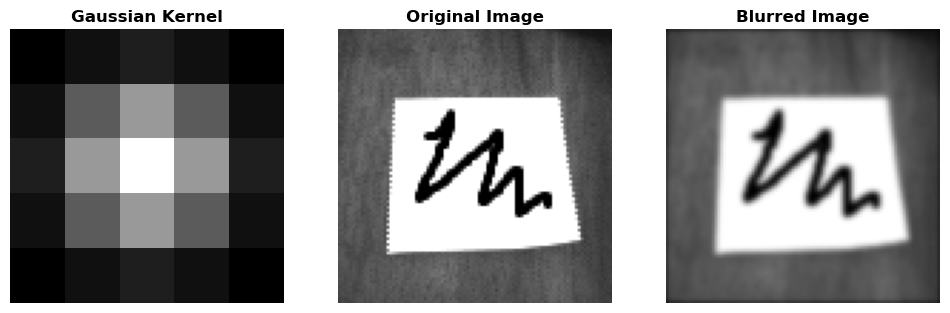

In [16]:
def gaussian_kernel(size, sigma=1):
    """Creates a Gaussian kernel given a size and standard deviation."""
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return g / g.sum()

def apply_gaussian_blur(image, kernel):
    """Applies Gaussian blur to an image using a specified kernel."""
    return convolve(image, kernel, mode='constant')

# Example
# Create a Gaussian kernel
kernel_size = 5
sigma = 1
gaussian_kernel = gaussian_kernel(kernel_size, sigma)

# Load an image and convert to grayscale
image = Image.open(r'figures/sticky_note.png').convert('L')

# Apply Gaussian blur
blurred_image = apply_gaussian_blur(image, gaussian_kernel)
save_array_as_png(blurred_image, r'figures/blurred_image.png')

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gaussian_kernel, cmap='gray')
plt.title('Gaussian Kernel')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

### 2.2. Convolution with a Sobel kernel

The idea with the Sobel kernel is to detect the gradient of the image. The Sobel kernel is a 2D kernel that is defined as follows:

$$
G_x = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
\quad
G_y = \begin{bmatrix}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix}
$$


(-0.5, 2.5, 2.5, -0.5)

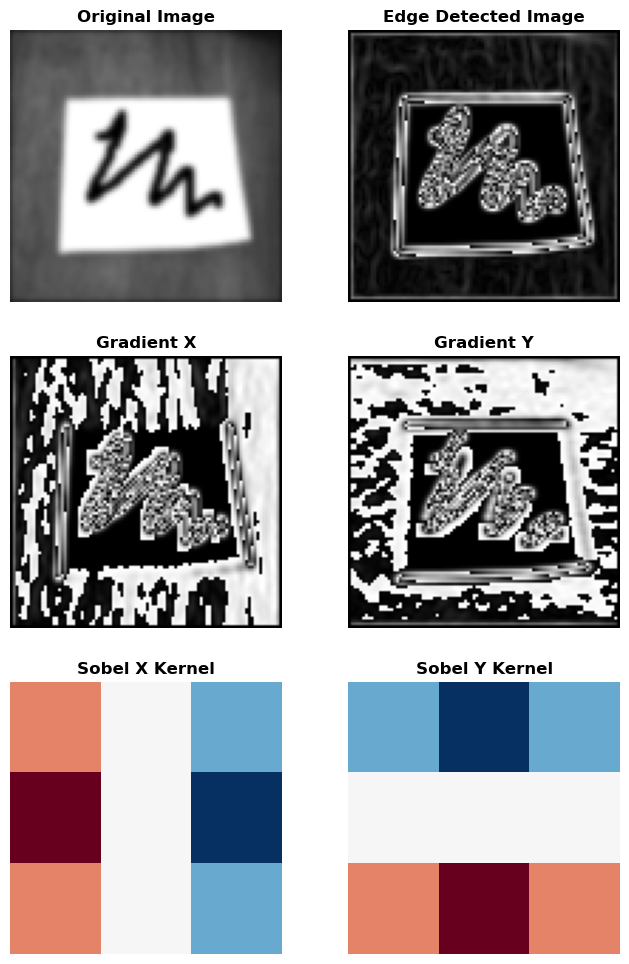

In [17]:
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

def sobel_edge_detection(image_array):
    # Image dimensions
    rows, cols = image_array.shape

    # Create an empty array to store the edge detected image
    gradient_x = np.zeros_like(image_array)
    gradient_y = np.zeros_like(image_array)
    edge_image = np.zeros_like(image_array)

    # Apply Sobel filter to the image
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            gx = np.sum(np.multiply(image_array[i-1:i+2, j-1:j+2], sobel_x))
            gy = np.sum(np.multiply(image_array[i-1:i+2, j-1:j+2], sobel_y))
            
            # Calculate the gradient magnitude
            gradient_x[i, j] = gx
            gradient_y[i, j] = gy
            edge_image[i, j] = np.sqrt(gx**2 + gy**2)

    # Normalize the image to the range [0, 255]
    edge_image = np.clip((edge_image / np.max(edge_image)) * 255, 0, 255).astype(np.uint8)
    gradient_x = np.clip((gradient_x / np.max(gradient_x)) * 255, 0, 255).astype(np.uint8)
    gradient_y = np.clip((gradient_y / np.max(gradient_y)) * 255, 0, 255).astype(np.uint8)

    return gradient_x, gradient_y, edge_image

# Load an image and convert to grayscale
image = Image.open(r'figures/blurred_image.png').convert('L')
image_array = np.array(image)

# Perform edge detection
grad_x, grad_y, edges = sobel_edge_detection(image_array)

# Plot the original, edge detected, and gradient images, as well as the kernels

fig, ax = plt.subplots(3, 2, figsize=(8, 12))
ax[0, 0].imshow(image_array, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(edges, cmap='gray')
ax[0, 1].set_title('Edge Detected Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(grad_x, cmap='gray')
ax[1, 0].set_title('Gradient X')
ax[1, 0].axis('off')

ax[1, 1].imshow(grad_y, cmap='gray')
ax[1, 1].set_title('Gradient Y')
ax[1, 1].axis('off')

ax[2, 0].imshow(sobel_x, cmap='RdBu')
ax[2, 0].set_title('Sobel X Kernel')
ax[2, 0].axis('off')

ax[2, 1].imshow(sobel_y, cmap='RdBu')
ax[2, 1].set_title('Sobel Y Kernel')
ax[2, 1].axis('off')

### Corner detection with the Harris algorithm

### <span style="color:red;"> Assignment: Design your own kernel </span>

In the following cell, design your own kernel and apply it to the image. Plot the kernel and the resulting image. What does your kernel do to the image?

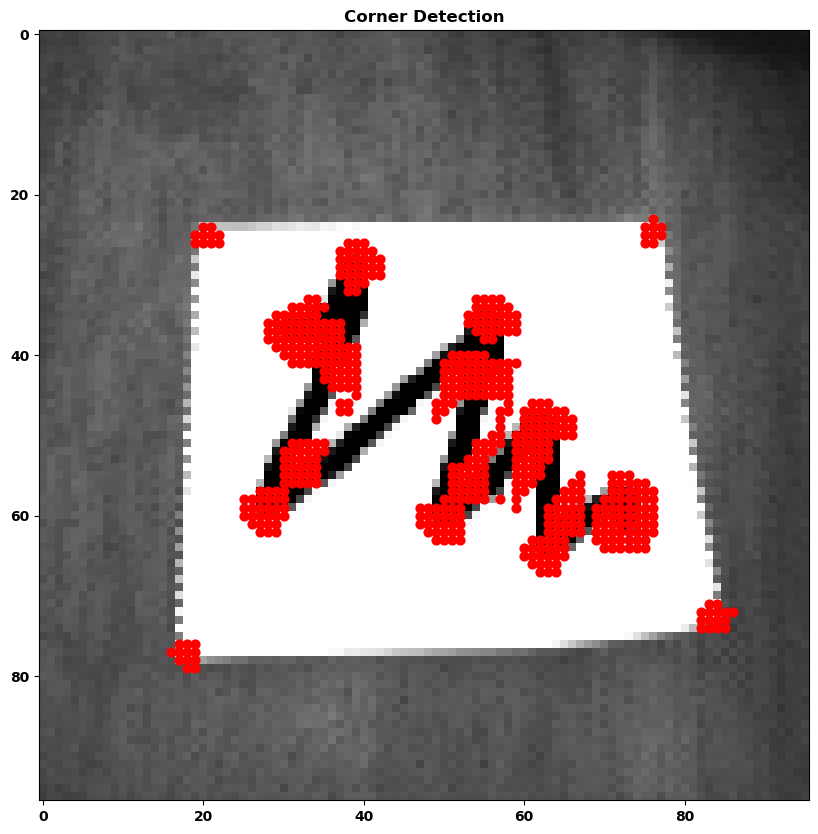

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

def sobel_filters(img):
    Kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)

    return Ix, Iy

def harris_corner_detector(image, window_size, k, threshold):
    # Step 1: Grayscale conversion if necessary
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)
    
    # Step 2: Find gradients
    Ix, Iy = sobel_filters(image)

    # Precompute products of derivatives
    Ixx = Ix**2
    Ixy = Ix*Iy
    Iyy = Iy**2

    height, width = image.shape
    corners = []
    
    # Step 3: Calculate the response of each pixel
    for y in range(window_size, height - window_size):
        for x in range(window_size, width - window_size):
            # Sum of products of derivatives for the window
            Sxx = np.sum(Ixx[y-window_size:y+window_size+1, x-window_size:x+window_size+1])
            Sxy = np.sum(Ixy[y-window_size:y+window_size+1, x-window_size:x+window_size+1])
            Syy = np.sum(Iyy[y-window_size:y+window_size+1, x-window_size:x+window_size+1])

            # Harris corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            R = det - k * (trace**2)

            # Step 4: If the response is above threshold, it's a corner
            if R > threshold:
                corners.append((x, y, R))

    corners = sorted(corners, key=lambda x: x[2], reverse=True)
    return corners

# Example usage
# Load your image as grayscale
image = plt.imread(r'figures/sticky_note.png')
corners = harris_corner_detector(image, window_size=2, k=0.04, threshold=100)

# Plot the image and the corners
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
for corner in corners:
    x, y, _ = corner
    plt.scatter([x], [y], c='r', s=40)
plt.title('Corner Detection')
plt.show()


### Finding the paper corners

[[86 72]
 [85 74]
 [19 79]
 [18 79]
 [16 77]
 [19 25]
 [20 24]
 [76 23]
 [77 24]]


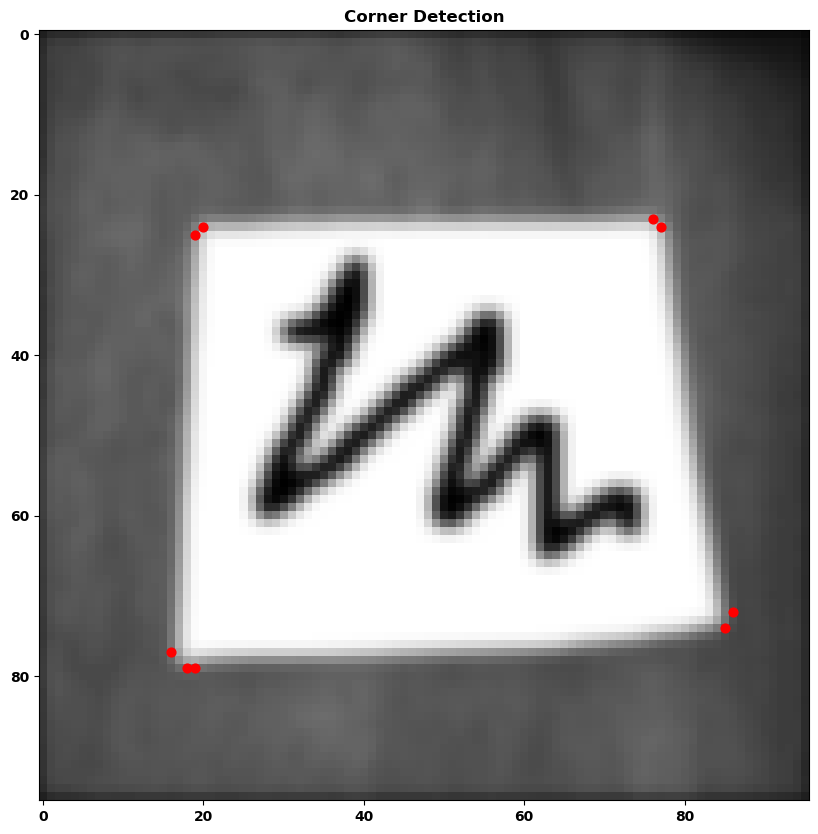

In [25]:
def filter_corners_by_margin(corners, margin, image_width, image_height):
    # Filter corners by a margin from the image border
    return [corner for corner in corners if margin < corner[0] < image_width - margin and margin < corner[1] < image_height - margin]

def find_largest_quadrilateral(corners):
    # Assuming the paper forms a convex quadrilateral, we find the convex hull
    points = np.array([[x, y] for x, y, _ in corners])
    hull = cv2.convexHull(points)

    # Assuming the paper is the largest quadrilateral, hull should now contain its corners
    return hull

# Example usage
image_np = plt.imread(r'figures/sticky_note.png')
image_height, image_width = image_np.shape[:2]
margin = 5  # Pixels from the edge of the image

# Filter corners by margin
filtered_corners = filter_corners_by_margin(corners, margin, image_width, image_height)

# Find the largest quadrilateral
paper_corners = find_largest_quadrilateral(filtered_corners).squeeze()
print(paper_corners)

# Plot the image and the corners
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
for corner in paper_corners:
    x, y = corner
    plt.scatter([x], [y], c='r', s=40)
plt.title('Corner Detection')
plt.show()


### <span style="color:red;"> Assignment: Select the right corner points </span>

The output "paper_corners" contains the coordinates of the corners of the paper. However, many different points are detected. In the following cell, select the right corner points and plot them on the image.

### 2.3 Edge detection with OpenCV

OpenCV is a library that is used for computer vision. It has many functions that are useful for image processing. In the following cell, we will use the OpenCV function `cv2.Canny` to detect edges in the image.

This algorithm is similar to what we have done, but it is more sophisticated. It uses a Sobel kernel to detect the gradient of the image, then it applies non-maximum suppression to thin the edges, and finally it applies hysteresis thresholding to remove weak edges.

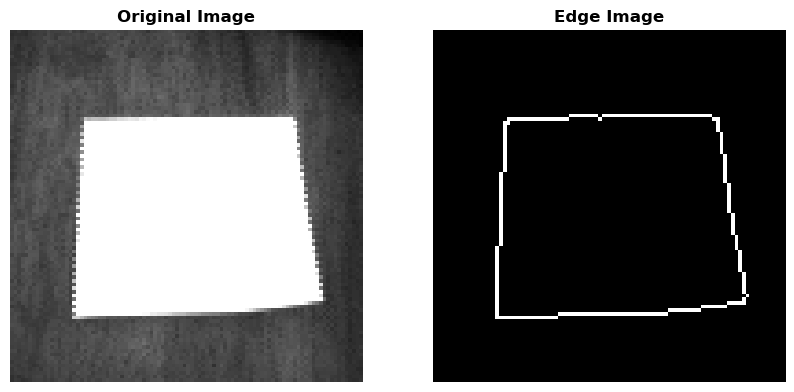

In [7]:
def edge_detection(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Canny edge detection
    edges = cv2.Canny(img, 100, 200)

    # Display the original and edged images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Image')
    plt.axis('off')

    plt.show()

# Replace 'path_to_image.jpg' with the path to your image file
edge_detection(r'figures/sticky_note.png')


### Corner decection with the Harris algorithm

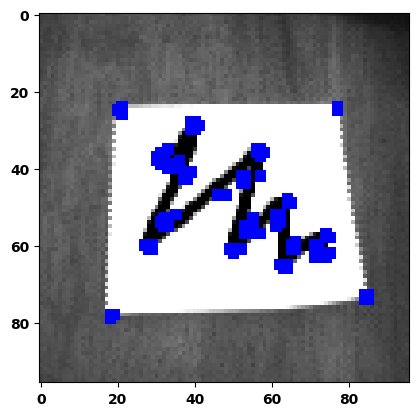

In [9]:
# Load your image
image = cv2.imread(r'figures/sticky_note.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert to float32 for more precision for corner detection
gray = np.float32(gray)

# Apply Harris corner detection
dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# Result is dilated for marking the corners
dst = cv2.dilate(dst, None)

# Threshold the corner response for actual corner detection
image[dst > 0.01 * dst.max()] = [0, 0, 255]

# Display the result
plt.imshow(image)

### Identify the corners

### Do a perspective transformation

In [ ]:
import cv2
import numpy as np

# Load the image
image_path = 'path_to_your_image.jpg'
image = cv2.imread(image_path)

# Points in the source image (the corners of the skewed paper)
# Replace these with the coordinates of the corners in your image
pts1 = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

# Points in the destination image (forming a rectangle)
pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

# Calculate the transformation matrix
matrix = cv2.getPerspectiveTransform(pts1, pts2)

# Apply the perspective transformation
result = cv2.warpPerspective(image, matrix, (width, height))

# Display the result
cv2.imshow('Transformed Image', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Optionally, save the transformed image
cv2.imwrite('path_to_save_transformed_image.jpg', result)
